In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import sin, cos, tan,pi,e

from cmath import asin
from cmath import sqrt,  exp
im = complex(0, 1)

#### R calculation:

In [2]:
def transfer_matrix(N1, N2):
    return np.array(([[(N2 + N1) / (2. * N2), (N2 - N1) / (2. * N2)], [(N2 - N1) / (2. * N2), (N2 + N1) / (2. * N2)]]), dtype=np.complex)

def N_calculation(n_first_media, incident_angle, n_current_media):
    return (n_current_media ** 2 - n_first_media ** 2 * (sin(incident_angle)) ** 2) ** 0.5

def phase_shift(x1, x2, x3):
    im = complex(0, 1.)
    zero = complex(0., 0.)
    x1 = x1/1000000000
    return np.array(([[exp(im*(x1 * x2 * x3)), zero], [zero, exp((-1)*im*(x1 * x2 * x3))]]), dtype=np.complex)

def R_func(dictionary_structure={}, wl=780, teta=45, d=0):
    list_N = []

    T = np.array([[1., 0.], [0., 1.]], dtype=np.complex)
    tet = teta * pi / 180
    k0 = 2 * 3.14159 * 1000000000 / wl
    n0 = complex(0., 0.)  # current n
    for i in range(len(dictionary_structure) - 1, 0, -1):
        if i == len(dictionary_structure) - 1:
            n0 = dictionary_structure[str(i)][1]['n']
            list_N.append(N_calculation(n0, tet, n0))

        if dictionary_structure[str(i - 1)][0]['name'] == 'ФК':
            n1 = dictionary_structure[str(i - 1)][1]['n1']
            n2 = dictionary_structure[str(i - 1)][3]['n2']
            d1 = dictionary_structure[str(i - 1)][2]['d1']
            d2 = dictionary_structure[str(i - 1)][4]['d2']
            num_layers = int(dictionary_structure[str(i - 1)][5]['N'])
            N1 = N_calculation(n0, tet, n1)
            N2 = N_calculation(n0, tet, n2)
            from_upper_to_1 = transfer_matrix(list_N[-1], N1)
            from_1_to_2 = transfer_matrix(N1, N2)
            from_2_to_1 = transfer_matrix(N2, N1)
            F_n1 = phase_shift(d1, N1, k0)  # x1 - d, x2 - N, x3 - k0
            F_n2 = phase_shift(d2, N2, k0)

            T = np.dot(from_upper_to_1, T)
            T = np.dot(F_n1, T)
            T = np.dot(from_1_to_2, T)
            T = np.dot(F_n2, T)
            for mmm in range(num_layers - 1):
                T = np.dot(from_2_to_1, T)
                T = np.dot(F_n1, T)
                T = np.dot(from_1_to_2, T)
                T = np.dot(F_n2, T)
            list_N.append(N1)
            list_N.append(N2)

        elif dictionary_structure[str(i - 1)][0]['name'] == 'Слой':
            n = dictionary_structure[str(i - 1)][1]['n']
            d = dictionary_structure[str(i - 1)][2]['d'] + d
            N = N_calculation(n0, tet, n)
            from_this_to_next = transfer_matrix(list_N[-1], N)
            F = phase_shift(d, N, k0)
            T = np.dot(from_this_to_next, T)
            T = np.dot(F, T)
            list_N.append(N)

        elif dictionary_structure[str(i - 1)][0]['name'] == 'Среда':
            n = dictionary_structure[str(i - 1)][1]['n']
            N = N_calculation(n0, tet, n)
            from_last_to_sub = transfer_matrix(list_N[-1], N)
            T = np.dot(from_last_to_sub, T)
            list_N.append(N)
    return (-(T[1, 0] / T[1, 1]))


In [3]:
def spectral(a, k):
    return abs(a/(2 * sqrt(pi)) * e**(-a * a * k * k / 4))

#### a - значение координаты, по уровню 1/e. Полная ширина = 2a. 
#### N_x - число гармоник по k_x, которые будем использовать
#### Меньшая гармоника будет по амплитуде составлять не больше 1/100

##### (50a - ограничимся таким масштабом по х)

In [184]:
a = 10
L = 780
N_x = 300

k_min = abs(sqrt(20. / a**2))
k = 2 * pi * 1000000000 / 780
print(k_min)
print(k/1000000)

0.4472135954999579
8.055365778435368


dk: 0.0029814239699997194
Угол сходимости, град: -3.1825535033832786


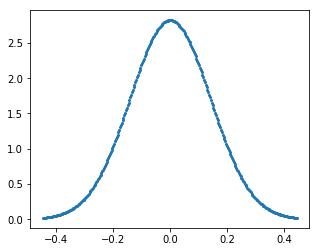

In [185]:
plt.figure(figsize=(5, 4))

dk_x = 2 *k_min / N_x

print("dk: " + str(dk_x))

k_n = np.arange(-N_x//2, N_x//2 )
k_x = k_n * dk_x
S_k = []

for i in (k_x):
    y_max = spectral(a, i)
    S_k.append(y_max)
print("Угол сходимости, град: " + str(asin(k_x[0] * 1000000 / k).real * 180 / pi))
    
plt.plot(k_x, S_k, 'o', markersize=2)

#### Прямая прогонка: рассчет прямого поля от падающего луча. Обратная прогонка рассчет отраженного луча. 
#### l - расстояние вдоль оси пучка, на которое мы недоюстировались. + - перефокусировка, -  - недофокусировка (желательно целое число микрон)
#### alpha - угол падения центральной спектральной компоненты 

In [205]:
X = np.arange(-60, 1200, 1)
Z = np.arange(0, 1200, 1)
E = np.zeros((len(Z), len(X)), dtype=np.complex)
l_0 = 700  # расстояние вдоль оси пучка до сфокусированного
l = 400
alpha = 45.9

h_0 = int(abs(l_0 * cos(alpha * pi / 180))) - 1
h = l * cos(alpha * pi / 180)
didic = {'0': [{'name': 'Среда'}, {'n': (1.52+0j)}], '1': [{'name': 'ФК'}, {'n1': (1.45+0j)}, {'d1': 204.0}, {'n2': (2.07+0j)}, {'d2': 143.0}, {'N': 10.0}], '2': [{'name': 'Слой'}, {'n': (1+0j)}, {'d': 300.0, 'd_final': 1.0}], '3': [{'name': 'Среда'}, {'n': (1.5+0j)}]}


In [ ]:

for j in range(Z[h_0], -1, -1):
    for i in range(0, 500, 1):
        Sum = 0
        for number_k_x, t in enumerate(k_x):
            teta = asin(t * 1000000 / k).real
            k_z = k / 1000000 * cos(teta)
            x_pos = X[i] * cos(pi * alpha / 180) + (Z[j] - h) * sin(pi * alpha / 180)
            z_pos = X[i] * sin(pi * alpha / 180) - (Z[j] - h) * cos(pi * alpha / 180)

            Sum = Sum + S_k[number_k_x] * exp(im * t * x_pos) * exp(im * k_z * z_pos)
        E[j][i] = Sum

In [ ]:
plt.figure(figsize=(9, 5))
plt.imshow(abs(E), cmap=plt.cm.hot, origin='lower', aspect='auto')    
#plt.xlim(46.6, 46.9)
cax = plt.axes([0.95, 0.13, 0.05, 0.75])
plt.colorbar(cax=cax)
plt.show()

In [172]:
R_teta = []
for number_k_x, t in enumerate(k_x):
    teta = asin(t * 1000000 / k).real
    #R_teta.append(1.)
    R_teta.append(R_func(teta=(alpha + teta * 180/pi) , wl=780, dictionary_structure=didic))
    
for j, current_Z in enumerate(Z):
    for i, current_X in enumerate(X):
        Sum = 0
        for number_k_x, t in enumerate(k_x):
            teta = asin(t * 1000000 / k).real
            k_z = k / 1000000 * cos(teta)
            #x_pos = current_X * cos(pi * 45.8 / 180) - current_Z * sin(pi * 45.8 / 180)
            #z_pos = current_X * cos(pi * 45.8 / 180) + current_Z * sin(pi * 45.8 / 180)
            
            x_pos = current_X * cos(pi * alpha / 180) + (-Z[j] - h) * sin(pi * alpha / 180)
            z_pos = current_X * sin(pi * alpha / 180) - (-Z[j] - h) * cos(pi * alpha / 180)
   
            Sum = Sum + S_k[number_k_x] * exp(im * t * x_pos) * exp(im * k_z * z_pos) * R_teta[number_k_x]
        E[j][i] = E[j][i] + Sum

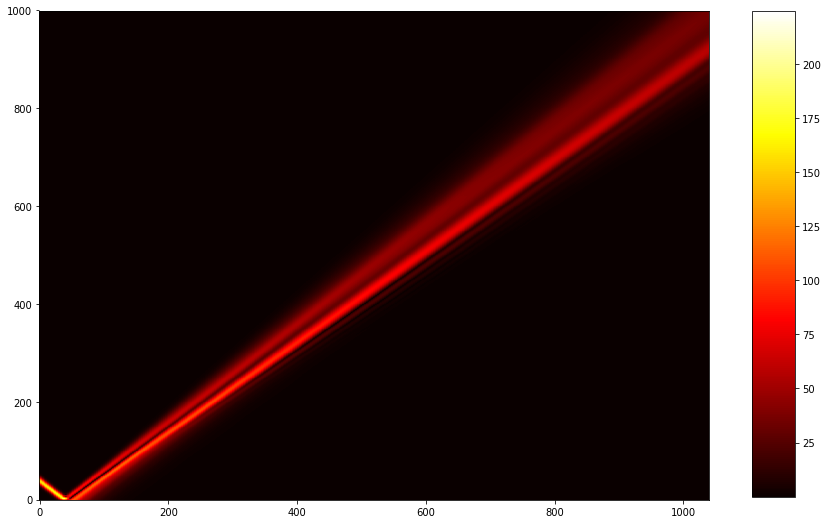

In [173]:
plt.figure(figsize=(12, 9))
plt.imshow(abs(E), cmap=plt.cm.hot, origin='lower', aspect='auto')    
#plt.xlim(46.6, 46.9)
cax = plt.axes([0.95, 0.13, 0.05, 0.75])
plt.colorbar(cax=cax)
plt.show()

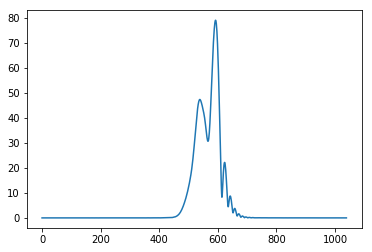

In [183]:
plt.plot(abs(E[500]))




In [176]:
fram = pd.DataFrame(data=abs(E))
fram.to_csv(r'c:\data\Gauss_5mcm_45.9_1040x1000.txt', header=None, index=None)

In [204]:
data = pd.read_csv("c:\data\Gauss_10mcm_45.9_1040x1000.txt", header=None)
plt.figure(figsize=(12, 9))
plt.imshow(data, cmap=plt.cm.hot, origin='lower', aspect='auto')    
#plt.xlim(46.6, 46.9)
cax = plt.axes([0.95, 0.13, 0.05, 0.75])
plt.colorbar(cax=cax)
plt.show()

In [ ]:
d_air = np.arange(0, 300, 1)
